# Preparing an AF state in the Ising model

The purpose of this notebook is to illustrate how to build a sequence for preparing an AF state in the Ising model. 

(This notebook is supposed to evolve with code updates.) 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip

from pulser import Pulse, Sequence, Register
from pulser.waveforms import ConstantWaveform, RampWaveform
from pulser.devices import Chadoq2, Mock
from pulser.simulation import Simulation

# 1. 2D Square Array

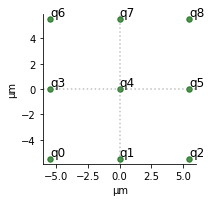

In [19]:
reg = Register.square(side = 3, spacing=5.5, prefix='q')
reg.draw()
device = Chadoq2

## Waveforms 

We are realizing the following program

<img src="files/AF_Ising_program.png" alt="AF Pulse Sequence" style="width: 320px;"/>

In [20]:
# Parameters in MHz and ns
#U = 1 * 2*np.pi  # btw 1-3 Mhz*2pi. Should we include this VdW magnitude in an AFM-type Simulation?

delta_0 = -2 * 2*np.pi
delta_f = 2 * 2*np.pi
Omega_max = 2.3 * 2*np.pi  # btw 1.8-2 Mhz*2pi
t_rise = 250
t_fall = 500
t_sweep = (delta_f-delta_0)/(2*np.pi*10) * 1000

In [21]:
rise = Pulse.ConstantDetuning(RampWaveform(t_rise, 0., Omega_max), delta_0, 0.)
sweep = Pulse.ConstantAmplitude(Omega_max, RampWaveform(t_sweep, delta_0, delta_f), 0.)
fall = Pulse.ConstantDetuning(RampWaveform(t_fall, Omega_max, 0.), delta_f, 0.)

## Creating my sequence

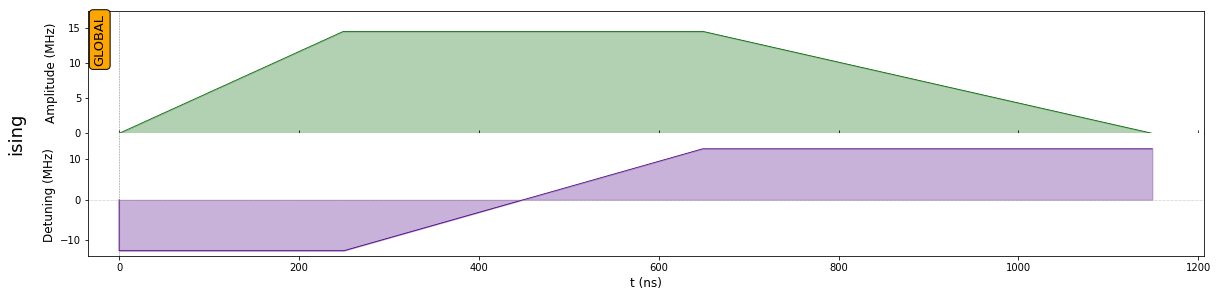

In [22]:
seq = Sequence(reg, Mock)
seq.declare_channel('ising', 'rydberg_global')

seq.add(rise, 'ising')
seq.add(sweep, 'ising')
seq.add(fall, 'ising')

#print(seq)
seq.draw()

## Phase Diagram

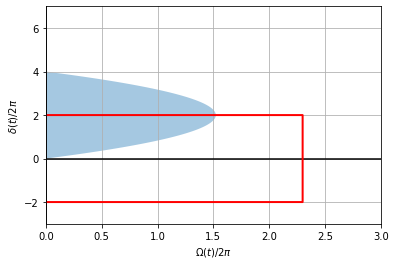

In [23]:
#phase = {'omega':[], 'delta':[], 'time': range(max(seq._last(ch).tf for ch in seq.declared_channels))}
delta = []
omega = []
for x in seq._schedule['ising']:
    if isinstance(x.type,Pulse):
        omega += list(x.type.amplitude.samples)
        delta += list(x.type.detuning.samples)
        
fig, ax = plt.subplots()
ax.grid(True, which='both')

ax.set_ylabel(r"$\delta(t)/2\pi$")
ax.set_xlabel(r"$\Omega(t)/2\pi$")
ax.set_xlim(0,3)
ax.set_ylim(-3,7)
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')

y = np.arange(0.0, 6, 0.01)
x = 1.522*(1-0.25*(y-2)**2)
ax.fill_between(x, y, alpha=0.4)

ax.plot(np.array(omega)/(2*np.pi),np.array(delta)/(2*np.pi),'red',lw=2)


# Simulation

In [24]:
simul = Simulation(seq)

In [25]:
up = qutip.basis(2,0)
def occupation(j):
    prod = [qutip.qeye(2) for _ in range(simul._size)]
    prod[j] = up*up.dag()
    return qutip.tensor(prod)
    
occup_list = [occupation(j) for j in range(simul._size)]

By parity symmetry, we only need to observe half of the atoms, the other one reflects the results

In [26]:
simul.run(obs_list=occup_list, progress_bar=True)

Observables provided. Calculating expectation value...
10.0%. Run time:  49.56s. Est. time left: 00:00:07:26
20.0%. Run time: 102.64s. Est. time left: 00:00:06:50
30.0%. Run time: 157.57s. Est. time left: 00:00:06:07
40.0%. Run time: 217.54s. Est. time left: 00:00:05:26
50.0%. Run time: 273.59s. Est. time left: 00:00:04:33
60.0%. Run time: 329.41s. Est. time left: 00:00:03:39
70.0%. Run time: 384.83s. Est. time left: 00:00:02:44
80.0%. Run time: 452.46s. Est. time left: 00:00:01:53
90.0%. Run time: 532.52s. Est. time left: 00:00:00:59
Total run time: 612.38s


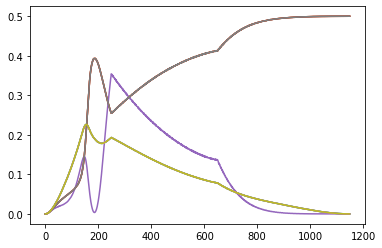

In [27]:
for expv in simul.output.expect:
    plt.plot(expv)

[[1.06894672e-05 4.99995472e-01 1.06894672e-05]
 [4.99995472e-01 8.55033814e-06 4.99995472e-01]
 [1.06894672e-05 4.99995472e-01 1.06894672e-05]]


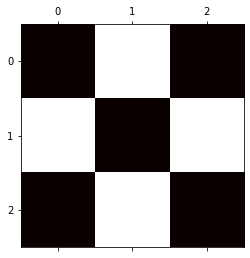

In [28]:
L = int(np.sqrt(len(reg.qubits)))
res=np.zeros((L,L))
for i,ev in enumerate(simul.output.expect):
    res[i//L,i%L] = ev[-1]
plt.matshow(res, cmap='hot')
print(res)

# 2. 1D Periodic Chain

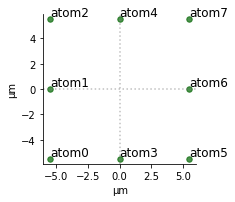

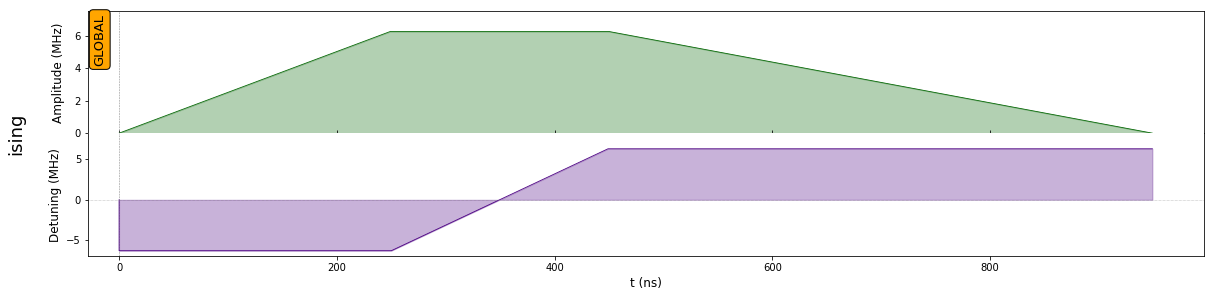

In [9]:
n_side = 3
coords = 6 * np.array([(x,y) for x in range(n_side) for y in range(n_side) 
                    if (x in {0,n_side-1} or y in {0,n_side-1})], dtype=np.float64)
reg = Register.from_coordinates(coords, prefix='atom')
reg.draw()

# Parameters in MHz and ns
#U = 1 * 2*np.pi  # btw 1-3 Mhz*2pi. Should we include this VdW magnitude in an AFM-type Simulation?

delta_0 = -1 * 2*np.pi
delta_f = 1 * 2*np.pi
Omega_max = 1 * 2*np.pi  # btw 1.8-2 Mhz*2pi
t_rise = 250
t_fall = 500
t_sweep = (delta_f-delta_0)/(2*np.pi*10) * 1000

rise = Pulse.ConstantDetuning(RampWaveform(t_rise, 0., Omega_max), delta_0, 0.)
sweep = Pulse.ConstantAmplitude(Omega_max, RampWaveform(t_sweep, delta_0, delta_f), 0.)
fall = Pulse.ConstantDetuning(RampWaveform(t_fall, Omega_max, 0.), delta_f, 0.)

seq = Sequence(reg, Mock)
seq.declare_channel('ising', 'rydberg_global')

seq.add(rise, 'ising')
seq.add(sweep, 'ising')
seq.add(fall, 'ising')

#print(seq)
seq.draw()

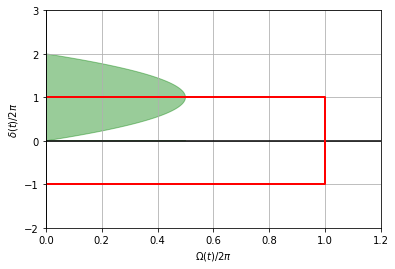

In [10]:
#phase = {'omega':[], 'delta':[], 'time': range(max(seq._last(ch).tf for ch in seq.declared_channels))}
delta = []
omega = []
for x in seq._schedule['ising']:
    if isinstance(x.type,Pulse):
        omega += list(x.type.amplitude.samples)
        delta += list(x.type.detuning.samples)
        
fig, ax = plt.subplots()
ax.grid(True, which='both')

ax.set_ylabel(r"$\delta(t)/2\pi$")
ax.set_xlabel(r"$\Omega(t)/2\pi$")
ax.set_xlim(0,1.2)
ax.set_ylim(-2,3)
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')

y = np.arange(0.0, 6, 0.01)
x = 0.5*(1-(y-1)**2)
ax.fill_between(x, y, color='green',alpha=0.4)

ax.plot(np.array(omega)/(2*np.pi),np.array(delta)/(2*np.pi),'red',lw=2)

Observables provided. Calculating expectation value...
10.0%. Run time:  15.37s. Est. time left: 00:00:02:18
20.0%. Run time:  31.40s. Est. time left: 00:00:02:05
30.0%. Run time:  47.73s. Est. time left: 00:00:01:51
40.0%. Run time:  64.89s. Est. time left: 00:00:01:37
50.0%. Run time:  82.39s. Est. time left: 00:00:01:22
60.0%. Run time: 100.07s. Est. time left: 00:00:01:06
70.0%. Run time: 117.71s. Est. time left: 00:00:00:50
80.0%. Run time: 135.87s. Est. time left: 00:00:00:33
90.0%. Run time: 153.92s. Est. time left: 00:00:00:17
Total run time: 172.10s
[[7.49995886e-01 1.93692764e-06 7.49995886e-01]
 [1.93692764e-06 0.00000000e+00 1.93692764e-06]
 [7.49995886e-01 1.93692764e-06 7.49995886e-01]]


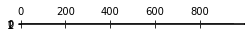

In [11]:
simul = Simulation(seq)

up = qutip.basis(2,0)
def occupation(j):
    prod = [qutip.qeye(2) for _ in range(simul._size)]
    prod[j] = up*up.dag()
    return qutip.tensor(prod)
    
occup_list = [occupation(j) for j in range(simul._size)]

simul.run(obs_list=occup_list, progress_bar=True)

[[7.49995886e-01 1.93692764e-06 7.49995886e-01]
 [1.93692764e-06 0.00000000e+00 1.93692764e-06]
 [7.49995886e-01 1.93692764e-06 7.49995886e-01]]


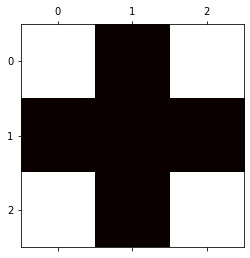

In [18]:
#Plot
L = n_side
res = np.zeros((L,L))
pos = [k for k in range(L*L) if (k//L in {0,L-1} or k%L in {0,L-1})] # valid position indexes in atom array
for i,ev in enumerate(simul.output.expect):
    x = pos[i]//L
    y = pos[i]%L
    res[x,y] = ev[-1]
plt.matshow(res, cmap='hot')
print(res)

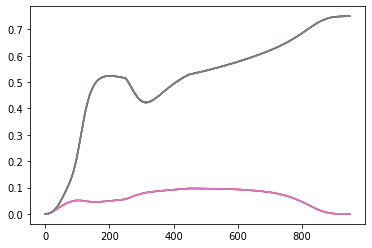

In [17]:
for expv in simul.output.expect:
    plt.plot(expv)